In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(memory_limit='16GB')
# client = Client(cluster)
# client

In [16]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [17]:
# Add a unique id to each sample
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata


,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [18]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['unique_id'] = sample['unique_id']
    eeg = eeg.set_index('unique_id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)


In [19]:
# Compute 150 signals to start
df = ddf.compute()
eeg_ids = list(set(df.index))
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
unique_id,,,,,,,,,,,,,,,,,,,
db76e9927,-14.780000,-33.049999,-8.910000,-5.600000,-21.650000,1.780000,-26.129999,9.850000,-16.209999,-33.310001,-17.459999,3.22,-5.170000,-14.370000,-13.94,-24.629999,-4.620000,-27.780001,-17.980000
db76e9927,-8.100000,-34.610001,-26.570000,-2.770000,-20.350000,0.660000,-35.130001,13.400000,-16.600000,-36.060001,-17.309999,15.12,-3.140000,-15.580000,-15.91,-25.969999,-1.740000,-28.480000,-20.629999
db76e9927,-3.530000,-34.709999,17.120001,15.570000,-19.110001,-0.770000,-24.709999,30.219999,-8.930000,-32.369999,-23.840000,-2.82,14.670000,-6.310000,-8.61,-20.760000,4.840000,-18.500000,-10.460000
db76e9927,-3.370000,-29.330000,13.520000,11.710000,-20.629999,-4.140000,10.330000,24.660000,-10.640000,-33.750000,-32.400002,-4.81,14.880000,-5.840000,-11.61,-24.910000,-2.940000,-18.680000,-13.950000
db76e9927,-3.830000,-27.459999,14.320000,-2.420000,-20.000000,-3.300000,-9.990000,19.590000,-12.090000,-35.860001,-27.650000,7.83,4.900000,-11.270000,-16.00,-27.860001,-4.780000,-25.540001,-20.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbdf2f28e,-39.990002,-11.380000,14.590000,-20.500000,-15.240000,-23.340000,-57.529999,-12.530000,7.420000,-20.930000,-16.010000,1.68,-3.070000,-1.150000,2.43,-0.170000,-23.500000,-6.850000,3.350000
bbdf2f28e,-74.470001,-50.410000,-10.230000,-46.110001,-35.630001,-53.380001,-85.099998,-32.070000,-14.630000,-38.250000,-40.669998,-25.49,-22.780001,-22.990000,-15.43,-26.559999,-49.869999,-26.160000,-22.389999
bbdf2f28e,-66.209999,-31.180000,-4.690000,-39.560001,-26.389999,-49.680000,-75.089996,-27.030001,-7.510000,-28.959999,-32.930000,-10.00,-10.790000,-11.880000,-5.56,-20.100000,-42.110001,-11.150000,-14.310000


In [20]:
# Apply filtering
from src.preprocessing.preprocessing import bp_filter, notch_filter
from scipy.signal import iirnotch, filtfilt, butter

def apply_notch_filter(df, fs, f0):
  filtered = df.copy()
  b,a = iirnotch(f0, 30, fs)
  for column in filtered.columns:
    filtered[column] = filtfilt(b, a, df[column])
  return filtered

def apply_bp_filter(df, fs, lowcut, highcut):
  filtered = df.copy()
  nyq = 0.5*fs
  low = lowcut / nyq
  high = highcut/nyq
  b,a = butter(5, [low,high], btype='band')
  for channel in filtered.columns:
    filtered[channel] = filtfilt(b,a, df[channel])
  return filtered


filtered_data = apply_notch_filter(df, 200, 60)
filtered_data = apply_bp_filter(filtered_data, 200, 0.5, 50)

/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# df
# from src.preprocessing.preprocessing import wavelet_transform
# from src.visualize import plot_signal
# import numpy as np

# sig = df.loc['db76e9927']
# plot_signal(sig, 5, ['F3',	'Fz',	'F4',	'F8',	'T3'])


In [22]:
from src.preprocessing.preprocessing import wavelet_transform
sig_denoised = wavelet_transform(df, 2, basis='bior3.3')

Extracting top 3 channels based on max variance for all samples
- 1000 samples computation duration = approx. 15 minutes

In [24]:
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(sig_denoised, eeg_ids, len(eeg_ids))
top_channels_df

,0,1,2
03ce1ba04,F3,Fp1,Fz
074b55d3d,Fp1,Fp2,Fz
c48bdda28,Fp2,Fp1,Fz
42fde4e24,Fp2,Fz,F8
e53213ae3,Fp1,F7,O1
...,...,...,...
1ce330e5b,O1,T5,T6
0d05b0b4b,F8,Fp1,Fp2
cf2a707d4,T6,P4,Fp2
4fb9790f4,F4,Fz,Fp1


Extracting Statistical Features from every sample with extraction function
- 1000 samples computation duration = approx. 20 minutes

In [25]:
from src.feature_extraction import extract_features_all_samples

features_df = extract_features_all_samples(df, top_channels_df)
features_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
03ce1ba04,55.087522,-41.45632,128.933332,-241.469996,3052.153158,-38.633333,-0.191037,3.242657,5.096749,30598654.666667,478907033591.196289
074b55d3d,144.141174,-5.810576,501.710002,-508.643321,23206.088379,-10.571667,0.54353,4.570005,5.359365,3011002485.333333,2326458770948.378906
c48bdda28,48.214787,-37.180627,130.083333,-196.543335,2342.987956,-36.773333,0.046213,3.475728,5.179415,19673173.666667,374658627962.911804
42fde4e24,20.297019,1.721797,72.393333,-71.806666,412.875682,2.866667,-0.265339,3.023871,5.074338,519116.604167,97566742579.368149
e53213ae3,14.009219,-23.11437,35.21,-98.420001,196.277095,-20.413333,-0.9108,5.996614,5.310643,230886.46875,76320166202.451462
...,...,...,...,...,...,...,...,...,...,...,...
1ce330e5b,27.947538,-2.238674,100.273333,-105.403336,809.191996,-5.356667,0.260656,5.25947,5.315312,4061612.208333,109055857079.025269
0d05b0b4b,50.092866,51.529699,243.223328,-149.079997,2511.391195,54.511668,-0.256265,3.307081,5.099168,20940888.666667,1416522874988.267822
cf2a707d4,6001.850586,815.590108,39853.403646,-12684.770182,36087473.333333,-45.335,4.883948,28.214108,5.637885,36453699565213016.0,3676156308628924.0
4fb9790f4,432.969952,-13.009503,677.266663,-697.650012,507593.864827,-13.156667,-0.033862,2.388315,4.673958,1182807551767.666748,50779628421690.90625


Setting up Feature Data and Target Data for correct format to split data and Input to Microsoft's Light Gradient Boosting Machine (LGBM)

In [26]:
# Setup feature table
# input_df = pd.merge(features_df, metadata[['unique_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']], left_index=True, right_on='unique_id')
input_df = pd.merge(features_df, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
03ce1ba04,55.087522,-41.45632,128.933332,-241.469996,3052.153158,-38.633333,-0.191037,3.242657,5.096749,30598654.666667,478907033591.196289,LRDA
074b55d3d,144.141174,-5.810576,501.710002,-508.643321,23206.088379,-10.571667,0.54353,4.570005,5.359365,3011002485.333333,2326458770948.378906,Seizure
c48bdda28,48.214787,-37.180627,130.083333,-196.543335,2342.987956,-36.773333,0.046213,3.475728,5.179415,19673173.666667,374658627962.911804,GRDA
42fde4e24,20.297019,1.721797,72.393333,-71.806666,412.875682,2.866667,-0.265339,3.023871,5.074338,519116.604167,97566742579.368149,Other
e53213ae3,14.009219,-23.11437,35.21,-98.420001,196.277095,-20.413333,-0.9108,5.996614,5.310643,230886.46875,76320166202.451462,GPD
...,...,...,...,...,...,...,...,...,...,...,...,...
1ce330e5b,27.947538,-2.238674,100.273333,-105.403336,809.191996,-5.356667,0.260656,5.25947,5.315312,4061612.208333,109055857079.025269,GRDA
0d05b0b4b,50.092866,51.529699,243.223328,-149.079997,2511.391195,54.511668,-0.256265,3.307081,5.099168,20940888.666667,1416522874988.267822,GPD
cf2a707d4,6001.850586,815.590108,39853.403646,-12684.770182,36087473.333333,-45.335,4.883948,28.214108,5.637885,36453699565213016.0,3676156308628924.0,Seizure


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


x = input_df.iloc[:, :11].astype(float)
y = input_df[['expert_consensus']].to_numpy().flatten()

categories = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

le = LabelEncoder()
le.fit(categories)
y = le.transform(y)


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=68)

Inputting Parameters for LGBM Model
- parameters were obtained by observing similiar implementation in same competition project using LGBM library. (see report doc --> citations/acknowledgements for more details) 
- Slight adjustments to parameters applied to fit our implementation

In [31]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
params = {
    'objective': 'multiclass',
    'num_class': 6,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 121,
    'learning_rate': 0.018623105710769177,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.756777580360579,
    'max_depth': 8,
    'verbose': 0
}

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score -1.779337
[LightGBM] [Info] Start training from score -1.764631
[LightGBM] [Info] Start training from score -1.993264
[LightGBM] [Info] Start training from score -1.801810
[LightGBM] [Info] Start training from score -1.757358
[LightGBM] [Info] Start training from score -1.680665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier()

Splitting Data 80/20 and adjusting params to obtain training and testing sets

Training our LGBM model on the training data and evaluating it on the test data - Probabilities for each target label are obtained and Displayed

Generating Confusion Matrix with predicted labels and true labels

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.38

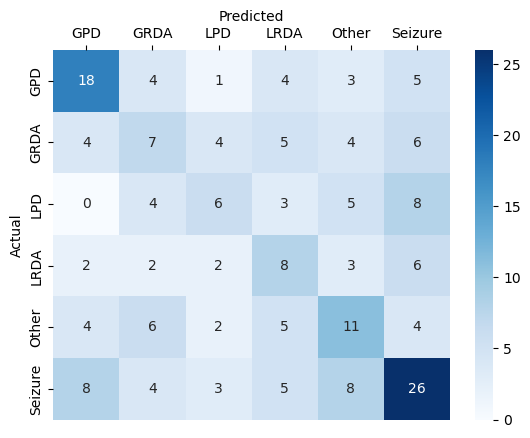

In [33]:
# Generate confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm)

cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')

hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()

Generating result metrics to evaluate our multiclassification model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [ ]:
y_pred_proba = lgb_model.predict_proba(X_test)

# Predicted probabilities to DataFrame
pred_df = pd.DataFrame(y_pred_proba, columns=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
pred_df['eeg_id'] = X_test.index
pred_df = pred_df[['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
pred_df

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.756777580360579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756777580360579


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,d9113372f,0.080506,0.193372,0.053684,0.539456,0.060246,0.072736
1,849d78c59,0.113656,0.061370,0.057785,0.050176,0.251453,0.465560
2,321ec68b1,0.204213,0.492116,0.061107,0.047273,0.134565,0.060726
3,3056b1db8,0.217029,0.071639,0.264824,0.282515,0.093404,0.070589
4,ca97c80ac,0.287136,0.173474,0.085093,0.203982,0.143696,0.106618
...,...,...,...,...,...,...,...
195,09d7ae280,0.393221,0.082665,0.094750,0.051549,0.100589,0.277225
196,237c52750,0.199151,0.141505,0.130557,0.080488,0.111967,0.336332
197,554a28223,0.047088,0.026941,0.040425,0.032745,0.672812,0.179989
198,0bced5c79,0.023507,0.064022,0.043848,0.018592,0.053891,0.796140


Preprocessing Data: Applying Wavelet Transform, Notch filter, Standardization to our data
- Model was trained without preprocessing due to higher scores without

In [ ]:
# File created to test the correctness of extracted values using MATLAB
# Save Fp1 channel data into a MATLAB file
# import scipy.io
# scipy.io.savemat('Fp1_data.mat', {'Fp1_data': sig1['Fp1']})

In [34]:
from joblib import dump
model = ... # your trained model
dump(model, 'model.joblib')


['model.joblib']

In [43]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [41]:
sample_input = X_train.loc["b48e07930"]

In [42]:
sample_input.to_csv('sample.csv')
